# 2022 Predictions (2021 until more data for 22 available)

In this notebook I am going to use practice/qualifying data to predict F1 race results.  A priori I don't expect this to work very well.  In the first iteration I will just take all lap times from practice and qualifying to predict each car's mean race pace.  Some immediate problems that will limit the accuracy are


-  Practice session mayhem
    1.  All teams purposefully limit the cars performance, use unknown amounts of fuel, ...
    2.  Teams do different types of runs (race sim, quali sim, testing new parts...  and more...). In principle I could try and sort out quali sim laps and race sim laps manually or with k-means clustering.  
    3.  Different times of day for practice/race/qualy effect track temperatures
    
-  Mid season upgrades



The first implementation will be 1 neural network for each driver, that takes all the practice & quali lap times as input and predicts the race pace.  


First we set up the FastF1 library and data directory.

In [5]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
import os

plotting.setup_mpl()

f1DataCache=os.path.join(os.path.expanduser('~'),'Documents','F1DataCache')
ff1.Cache.enable_cache(f1DataCache)

In [35]:
ff1.get_event_schedule(2021).EventName

0               Pre-Season Test
1            Bahrain Grand Prix
2     Emilia Romagna Grand Prix
3         Portuguese Grand Prix
4            Spanish Grand Prix
5             Monaco Grand Prix
6         Azerbaijan Grand Prix
7             French Grand Prix
8            Styrian Grand Prix
9           Austrian Grand Prix
10           British Grand Prix
11         Hungarian Grand Prix
12           Belgian Grand Prix
13             Dutch Grand Prix
14           Italian Grand Prix
15           Russian Grand Prix
16           Turkish Grand Prix
17     United States Grand Prix
18       Mexico City Grand Prix
19         São Paulo Grand Prix
20             Qatar Grand Prix
21     Saudi Arabian Grand Prix
22         Abu Dhabi Grand Prix
Name: EventName, dtype: object

In [106]:
weekend=ff1.get_event(2021, 'Qatar')
fp1=weekend.get_practice(1)

In [107]:
fp1.load()
fp1.load_laps()

core           INFO 	Loading data for Qatar Grand Prix - Practice 1 [v2.2.1]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for track_status_data. Loading data...
api            INFO 	Fetching track

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,SpeedFL,SpeedST,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate
0,0 days 00:14:16.293000,3,0 days 00:02:02.719000,1,1,0 days 00:12:17.708000,NaT,0 days 00:00:47.510000,0 days 00:00:33.088000,0 days 00:00:42.121000,...,297.0,306.0,HARD,1.0,True,0 days 00:12:17.708000,McLaren,RIC,1,False
1,0 days 00:15:45.485000,3,0 days 00:01:29.192000,2,1,NaT,NaT,0 days 00:00:29.686000,0 days 00:00:29.941000,0 days 00:00:29.565000,...,309.0,305.0,HARD,2.0,True,0 days 00:14:16.293000,McLaren,RIC,1,True
2,0 days 00:18:05.473000,3,0 days 00:02:19.988000,3,1,NaT,NaT,0 days 00:00:42.847000,0 days 00:00:46.136000,0 days 00:00:51.005000,...,306.0,315.0,HARD,3.0,True,0 days 00:15:45.485000,McLaren,RIC,1,True
3,0 days 00:19:32.200000,3,0 days 00:01:26.727000,4,1,NaT,NaT,0 days 00:00:28.728000,0 days 00:00:29.171000,0 days 00:00:28.828000,...,308.0,307.0,HARD,4.0,True,0 days 00:18:05.473000,McLaren,RIC,1,True
4,0 days 00:21:31.062000,3,0 days 00:01:58.862000,5,1,NaT,NaT,0 days 00:00:35.068000,0 days 00:00:38.423000,0 days 00:00:45.371000,...,307.0,317.0,HARD,5.0,True,0 days 00:19:32.200000,McLaren,RIC,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0 days 01:07:58.588000,99,0 days 00:01:31.680000,20,4,NaT,NaT,0 days 00:00:30.282000,0 days 00:00:30.732000,0 days 00:00:30.666000,...,290.0,296.0,HARD,13.0,False,0 days 01:06:26.908000,Alfa Romeo Racing,GIO,1,True
453,0 days 01:09:30.080000,99,0 days 00:01:31.492000,21,4,NaT,NaT,0 days 00:00:30.264000,0 days 00:00:30.688000,0 days 00:00:30.540000,...,297.0,304.0,HARD,14.0,False,0 days 01:07:58.588000,Alfa Romeo Racing,GIO,1,True
454,0 days 01:11:03.253000,99,0 days 00:01:33.173000,22,4,NaT,NaT,0 days 00:00:30.219000,0 days 00:00:31.929000,0 days 00:00:31.025000,...,299.0,307.0,HARD,15.0,False,0 days 01:09:30.080000,Alfa Romeo Racing,GIO,2,True
455,0 days 01:12:34.434000,99,0 days 00:01:31.181000,23,4,NaT,NaT,0 days 00:00:29.916000,0 days 00:00:30.809000,0 days 00:00:30.456000,...,291.0,296.0,HARD,16.0,False,0 days 01:11:03.253000,Alfa Romeo Racing,GIO,1,True


In [108]:
lapTimes=fp1.laps.pick_driver('VER').LapTime.dropna()

In [109]:
lapTimes.size

19

In [110]:
import pandas as pd
lapTimes = []
driverTLA = {}
myPalette = {}
for driver in fp1.drivers:
    TLA=ff1.api.driver_info(fp1.api_path)[driver]['Tla']
    driverTLA[driver]=TLA
    myPalette[TLA]=ff1.plotting.team_color(ff1.api.driver_info(fp1.api_path)[driver]['TeamName'])
for driver in fp1.drivers:
    for lapTime in fp1.laps.pick_driver(driver).LapTime.dropna():
        lapTimes.append([driverTLA[driver], lapTime])
lapTimes=pd.DataFrame(lapTimes,columns=['driver', 'lap_time'])
type(lapTimes)
lapTimes

api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for driver_info
api       

,driver,lap_time
0,RIC,0 days 00:02:02.719000
1,RIC,0 days 00:01:29.192000
2,RIC,0 days 00:02:19.988000
3,RIC,0 days 00:01:26.727000
4,RIC,0 days 00:01:58.862000
...,...,...
370,GIO,0 days 00:01:56.644000
371,GIO,0 days 00:01:31.680000
372,GIO,0 days 00:01:31.492000
373,GIO,0 days 00:01:33.173000


In [111]:
import seaborn as sns


In [112]:
sns.set_theme(style="ticks", palette="pastel")

<AxesSubplot:xlabel='lap_time', ylabel='driver'>

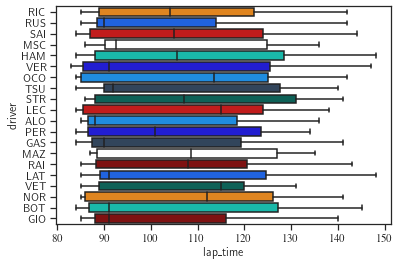

In [113]:
sns.boxplot(y=lapTimes["driver"], x=lapTimes["lap_time"].astype('timedelta64[s]'),
           palette=myPalette)